In [134]:
import artif_gen_methods as agm
import config
import helper_fxns as hf
import importlib
import matplotlib.pyplot as plt
%matplotlib inline

In [283]:
importlib.reload(hf)
importlib.reload(config)
importlib.reload(agm)
C = config.Config()

In [275]:
n=1500

In [167]:
agm.gen_imgs("cyst", C, n)

In [284]:
#agm.gen_imgs("hcc", C, n)
#agm.gen_imgs("hemangioma", C, n)
#agm.gen_imgs("cholangio", C, n)
#agm.gen_imgs("colorectal", C, n)
agm.gen_imgs("fnh", C, n)

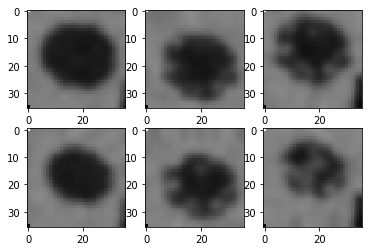

In [163]:
img = agm.gen_hemangiomas(C, 30)[28]
img = agm.post_process_img(img, C)
hf.plot_section_auto_scan(img, 0.3)

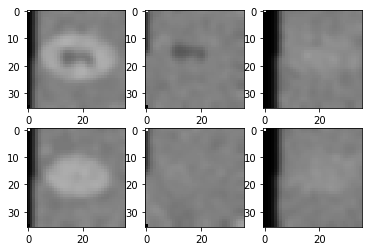

In [273]:
img = agm.gen_fnhs(C, 30)[27]
img = agm.post_process_img(img, C)
hf.plot_section_auto_scan(img, 0.3)

In [193]:
# hemangiomas add nodular enhancement, including in arterial; may fill in completely
# cholangios add variation in amount of enhancement over time
# check distortions along other axes
# different scales between planes
# look at colorectal cases and try to match
# add fnh

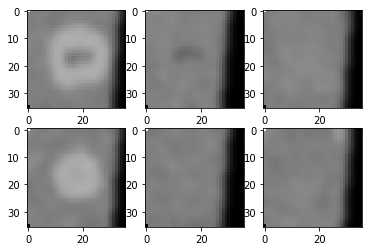

In [285]:
cls = "fnh"
img = np.load(C.artif_dir + cls + "\\artificial_150.npy")
hf.plot_section_auto_scan(img, 0.3)